In [20]:
# Buratino: A Golden Key to Understanding the Millisecond-Scale Autoscaling

# The Buratino simulator's goal is to provide the fast and cheap testing ground
# for the autoscaling policies/mechanism used in interactive transaction-based
# applications deployed in the cloud using the containers.
# The following models constitute the simulator:
# 1) application model - determines the logical structure of the application, i.e.
# which services communicate, how much time is required to process particular requests,
# how large are the buffers for storing the queries awaiting the processing. Overall,
# the application is represented as a general networked queueing model.
# The components of the model:
# - static -> the connections forming the logic of the application + processing times
# - dynamic -> the amount of instances of the application services (containers)
# 2) workload/load model - determines the load generated by the users of the application,
# i.e. requests times, distribution of the requests in time (e.g. diurnal, seasonal),
# the composition of the workload mixture (i.e. distribution of requests in terms of
# required processing times, e.g. 80% small reqs, 20% large ones)
# 3) scaling model - determines the scaling behaviour of the application, i.e. how
# much time might be required to take/conduct the scaling decision.
# 4) service level model - determines the expected level(s) of the service provided by
# the application as a whole, e.g. in terms of the response times or distirbutions thereof,
# in terms of services availability.
# 5) platform model (hardware/ virtual machines) - models the most relevant characteristics
# of the platform in terms of performance, e.g. the number of hw threads/cores that might
# be needed to known to accomodate the demands of the logical service instance in terms
# of threads. Note: we are not solving the placement problem! This is something done
# by the cloud services provider.
# 6) cost model - models the cost of the platform resource used during the simulation.
# 7) failure/availability model - determines the failure mode of the platform/app, s.t.
# the scaling procedure should be able to compensate for the unpredictably failing nodes.
# 8) performance interference/tenancy model - determines, how much CPU stealing can happen
# on the platform shared between the simulated application and some other application
# co-deployed in the cloud on the same infra.
# 9) scaling policy - provides a scaling plan that is executed by the simulation,
# follows a particular instance or the combination thereof of scaling policies.
# 10) network model - determines link latencies and bandwidth
# 11) deployment model - determines initial state of the app deployment, integrated into app config

In [21]:
# Hypotheses to check:
# 1) utilization-based autoscaling may fail to give the application owner better 
# service level -- hence, not the same as the workload-based autoscaling
# 2) reactive autoscaling policy (any! both util-based and w/l-based) suffers to scale correctly for the incoming workload
# on the millisecond scale (flash crowd) even if the scaling constants are to the 
# advantage thereof (instant scaling)

In [22]:
# Simulator's assumptions:
# 1) Requests chains separation -> requests made by the user do not depend on other
# requests by the user, although they can generate multiple other requests.
# 2) Simulation step is smaller or equal to the processing duration at the smallest
# component.
# 3) No retries are performed if requests fails due to some issue, e.g. overfull buffers,
# not enough throughput on the links, timeout reached
# 4) All the nodes in the same geographical region. This assumption is valid since
# the autoscalers often act independently on each region.
# 5) Request is processed at once by the service w/o interruptions. Future: implement OS sched

In [23]:
import uuid
import random
import json
import numpy as np
import os
import pickle
import math
from collections import deque
from abc import ABC, abstractmethod
from datetime import datetime
from tqdm import tqdm

In [291]:
os.path.exists('experimentjs')
os.path.join('experiments/test','t1.json')

'experiments/test/t1.json'

In [24]:
class SlicedRequestsNumDistribution(ABC):
    """
    Abstract base class for generating the random number of requests
    based on the corresponding distribution registered with it.
    The class registered with it should define own generate method.
    """
    @abstractmethod
    def generate(self, num):
        pass
    
    @abstractmethod
    def set_avg_param(self, avg_param):
        pass
    
class NormalDistribution:
    """
    Generates the random number of requests in the time slice
    according to the normal distribution. Wraps the corresponding
    call to the np.random.normal.
    """
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def generate(self, num = 1):
        return np.random.normal(self.mu, self.sigma, num)
    
    def set_avg_param(self, avg_param):
        self.mu = avg_param

# Registering the derived sliced request number generators
SlicedRequestsNumDistribution.register(NormalDistribution)

class WorkloadModel:
    """
    Represents the workload generation model.
    The parameters are taken from the corresponding JSON file passed to the ctor.
    The overall process for the workload generation works as follows:
    
        If the seasonal pattern of the workload is defined in terms of per interval values (cur. only per
        hour values are supported!) then each such value is uniformly split among seconds in the given
        hour (taken from the timestamp of the generate_requests call) s.t. each seconds in an hout gets
        its own quota in terms of requests to be produced during this second. These values are computed and
        stored in current_means_split_across_hour_seconds only if they were not computed before for the
        given hour current_hour.
        
        Following, these per-second values are used as parameters for the generative random distribution
        (e.g. as mean value for the normal distribution) -- the generated random value is used as
        an adjusted per second quota for each type of request separately, normalized by the ratio param.
        
        Next, the adjusted per request per second quota is uniformly distributed among the *step units*
        of the second. The number of step units is the number of millisecond size intervals of
        simulation_step_ms duration that fit into the second. The computation is only conducted if
        it was not done before for the currently considered second in an hour, i.e. cur_second_in_hour.
        The data structure with the buckets that correspond to step units is current_req_split_across_simulation_steps.
        
        Lastly, we select a bucket of the current_req_split_across_simulation_steps which
        the <second * 1000 + milliseconds>th millisecond of the timestamp_ms falls into. The selected value
        is the number of requests generated & returned for the given timestamp. 
    
    Properties:
    
        simulation_step_ms (int):                          simulation step in milliseconds, used to compute
                                                           the uniform distribution of the requests to generate
                                                           in the second (ms buckets); passed by the Simulator.
        
        reqs_types_ratios (dict):                          ratio of requests (value) of the given request type (key)
                                                           in the mixture; from config file.
        
        reqs_generators (dict):                            random sliced requests num generator (value) for the
                                                           request type (key); from config file.
        
        monthly_vals (dict):                               contains records for each month (1-12) and for the
                                                           wildcard month, i.e. any month (0); each record
                                                           holds the average numbers of requests (all types
                                                           together) on a per hour basis for each day of the week
                                                           (mon - 0, ... sun - 6). Thus, the structure is:
                                                           month -> weekday -> hour -> avg requests number;
                                                           from config file.
        
        discretion_s (int):                                the discretion (resolution) at which the avg request
                                                           numbers are stored in the monthly_vals structure;
                                                           from config file. Currently supports only hourly resolution.
        
        ********************************************************************************************************
        
        current_means_split_across_hour_seconds (dict):    contains the uniform split of
                                                           the avg requests number from monthly_vals (per hour)
                                                           into the seconds of the current_hour.
        
        current_second_leftover_reqs (dict):               tracks, how many more requests can be distributed
                                                           among milliseconds bins of the cur_second_in_hour
                                                           for the given request type. The distribution is in
                                                           current_req_split_across_simulation_steps.
        
        current_req_split_across_simulation_steps (dict):  holds the distribution of the requests number in
                                                           the bins of cur_second_in_hour per each request type.
        
        current_hour (int):                                current hour of the day for the timestamp_ms of the
                                                           generate_requests() call. Used to retrieve the
                                                           avg requests number from monthly_vals.
        
        cur_second_in_hour (int):                          current second in hour for the timestamp_ms
        
        workload (dict):                                   array of the numbers of requests generated for the timestamp (value) for the given
                                                           request type
                     
    Methods:
        generate_requests (timestamp_ms):                  generates a mixture of requests (list) using the reqs_types_ratios
                                                           and reqs_generators with the provided timestamp.
    
    Usage:
        wkldmdl = WorkloadModel(10, filename = 'experiments/test/workload.json')
        len(wkldmdl.generate_requests(100))
        
    TODO:
        implement support for holidays etc.
    """
    def __init__(self,
                 simulation_step_ms,
                 reqs_types_ratios = None,
                 filename = None):
        
        # Static state
        self.simulation_step_ms = simulation_step_ms
        self.reqs_types_ratios = {}
        self.reqs_generators = {}
        self.monthly_vals = {}
        self.discretion_s = 0
        
        if filename is None:
            raise ValueError('Configuration file not provided for the WorkloadModel.')
        else:
            with open(filename) as f:
                config = json.load(f)
                if config["seasonal_pattern"]["type"] == "values":
                    self.discretion_s = config["seasonal_pattern"]["discretion_s"]
                    
                    for pattern in config["seasonal_pattern"]["params"]:
                        
                        month_id = 0
                        if not pattern["month"] == "all":
                            month_id = int(pattern["month"])
                            
                        if not month_id in self.monthly_vals:
                            self.monthly_vals[month_id] = {}
                        
                        if pattern["day_of_week"] == "weekday":
                            for day_id in range(5):
                                self.monthly_vals[month_id][day_id] = pattern["values"]
                        elif pattern["day_of_week"] == "weekend":
                            for day_id in range(5, 7):
                                self.monthly_vals[month_id][day_id] = pattern["values"]
                        else:
                            raise ValueError('day_of_week value {} undefined for the WorkloadModel.'.format(pattern["day_of_week"]))
                    
                for conf in config["workloads_configs"]:
                    req_type = conf["request_type"]
                    req_ratio = conf["workload_config"]["ratio"]
                    if req_ratio < 0.0 or req_ratio > 1.0:
                        raise ValueError('Unacceptable ratio value for the request of type {}.'.format(req_type))
                    self.reqs_types_ratios[req_type] = req_ratio
                     
                    req_distribution_type = conf["workload_config"]["sliced_distribution"]["type"]
                    req_distribution_params = conf["workload_config"]["sliced_distribution"]["params"]
                    
                    if req_distribution_type == "normal":
                        mu = 0.0
                        sigma = 0.1
                        
                        if len(req_distribution_params) > 0:
                            mu = req_distribution_params[0]
                        if len(req_distribution_params) > 1:
                            sigma = req_distribution_params[1]
                        
                        self.reqs_generators[req_type] = NormalDistribution(mu, sigma)
                    
        # Dynamic state  
        self.current_means_split_across_hour_seconds = {} 
        for s in range(self.discretion_s):
            self.current_means_split_across_hour_seconds[s] = 0
        self.current_second_leftover_reqs = {}
        for req_type, _ in self.reqs_types_ratios.items():
            self.current_second_leftover_reqs[req_type] = -1
        self.current_req_split_across_simulation_steps = {} 
        for req_type, _ in self.reqs_types_ratios.items():
            ms_division = {}
            for ms_bucket_id in range(1000 // self.simulation_step_ms):
                ms_division[ms_bucket_id] = 0   
            self.current_req_split_across_simulation_steps[req_type] = ms_division
        self.current_hour = -1
        self.cur_second_in_hour = -1
        self.workload = {}    
        
    def generate_requests(self,
                          timestamp_ms):
        gen_reqs = []
        
        # Check if the split of the seasonal workload across the seconds of the hour is available
        query_dt = datetime.fromtimestamp(int(timestamp_ms / 1000))
        if not query_dt.hour == self.current_hour:
            # Generate the split if not available
            self.current_hour = query_dt.hour
            
            if len(self.monthly_vals) > 0:
                month_id = 0
                if query_dt.month in self.monthly_vals:
                    month_id = query_dt.month
                    
                # TODO: currently only supported per hour vals
                avg_reqs_val = self.monthly_vals[month_id][query_dt.weekday()][query_dt.hour]
                if not self.discretion_s == 3600:
                    raise ValueError('Currently, only hourly discretion is supported for the requests generation.')
                else:
                    for s in range(self.discretion_s):
                        self.current_means_split_across_hour_seconds[s] = 0
                        
                    for _ in range(avg_reqs_val):  
                        hour_sec_picked = np.random.randint(self.discretion_s)
                        self.current_means_split_across_hour_seconds[hour_sec_picked] += 1
        
        # Generating initial number of requests for the current second
        cur_second_in_hour = query_dt.minute * 60 + query_dt.second
        avg_param = self.current_means_split_across_hour_seconds[cur_second_in_hour]
        
        if not self.cur_second_in_hour == cur_second_in_hour: 
            for key, _ in self.current_second_leftover_reqs.items():
                self.current_second_leftover_reqs[key] = -1
            self.cur_second_in_hour = cur_second_in_hour
        
        for req_type, ratio in self.reqs_types_ratios.items():
            if self.current_second_leftover_reqs[req_type] < 0:
                self.reqs_generators[req_type].set_avg_param(avg_param)
                num_reqs = self.reqs_generators[req_type].generate()
                req_types_reqs_num = int(ratio * num_reqs)
                if req_types_reqs_num < 0:
                    req_types_reqs_num = 0
                    
                self.current_second_leftover_reqs[req_type] = req_types_reqs_num
                
                for key, _ in self.current_req_split_across_simulation_steps[req_type].items():
                    self.current_req_split_across_simulation_steps[req_type][key] = 0
        
                for _ in range(self.current_second_leftover_reqs[req_type]):
                    ms_bucket_picked = np.random.randint(len(self.current_req_split_across_simulation_steps[req_type]))
                    self.current_req_split_across_simulation_steps[req_type][ms_bucket_picked] += 1
        
        # Generating requests for the current simulation step
        for req_type, ratio in self.reqs_types_ratios.items():
            ms_bucket_picked = (timestamp_ms - int(query_dt.timestamp() * 1000) ) // self.simulation_step_ms
            req_types_reqs_num = self.current_req_split_across_simulation_steps[req_type][ms_bucket_picked]

            for i in range(req_types_reqs_num):
                req = Request(req_type)
                gen_reqs.append(req)
                self.current_req_split_across_simulation_steps[req_type][ms_bucket_picked] -= 1
                
            if req_type in self.workload:
                self.workload[req_type].append((timestamp_ms, req_types_reqs_num))
            else:
                self.workload[req_type] = [(timestamp_ms, req_types_reqs_num)]
                
        return gen_reqs

In [25]:
class Request:
    def __init__(self,
                 request_type,
                 request_id = None):
        # Static state
        self.request_type = request_type
        if request_id is None:
            self.request_id = uuid.uuid1()
        else:
            self.request_id = request_id
        
        # Dynamic state
        self.processing_left_ms = 0
        self.cumulative_time_ms = 0
        self.upstream = True
        self.replies_expected = 1 # to implement the fan-in on the level of service
        
    def set_downstream(self):
        self.upstream = False
    
class RequestProcessingInfo:
    def __init__(self,
                 request_type,
                 entry_service,
                 processing_times,
                 timeout_ms,
                 request_size_b,
                 response_size_b,
                 request_operation_type):
        
        self.request_type = request_type
        self.entry_service = entry_service
        self.processing_times = processing_times
        self.timeout_ms = timeout_ms
        self.request_size_b = request_size_b
        self.response_size_b = response_size_b
        self.request_operation_type = request_operation_type

In [26]:
class LinkBuffer:
    """
    Combines link and the buffer. The requests in the link advance when the step method is called.
    If the processing time left (i.e. waiting on the link) is over, the request proceeds to the
    buffer, where it can be extracted from for the further processing in a service.
    If the used throughput reached the throughput limit, the request is lost. The same happens
    if upon the transition to the buffer, the buffer is full for the given request type.
    
    Properties:
    
        As buffer:
            capacity_by_request_type (dict):  holds capacity of the buffer by request type, in terms of
                                              requests currently placed in the buffer
                                              
            [STUB] policy:                    policy used for moving requests in the buffer, e.g. FIFO/LIFO
            
            ********************************************************************************************************
            
            requests (collections.deque):     holds current requests in the buffer
            
            reqs_cnt (dict):                  holds current request count by the request type, used to rapidly check
                                              if more requests of the given type can be accomodated in the buffer
            
        As link:
            latency_ms (int):                 latency of the link in milliseconds, taken from the config
            
            throughput_mbps (int):            throughput of the link in Megabytes per sec, taken from the config
            
            request_processing_infos (dict):  holds requests processing information to compute the used
                                              throughput etc.
            
            ********************************************************************************************************
            
            requests_in_transfer (list):      holds requests that are currently "transferred" by this link
            
            used_throughput_MBps (int):       throughput currently used on this link by the "transferred" reqs
        
    Methods:
    
        As buffer:
            append_left (req):                puts the request req at the beginning of the buffer to give other
                                              requests opportunity to be processed if the current request waits
                                              for other replies to get processed (fan-in)
            
            pop:                              takes the last added request out of the buffer for processing (LIFO)
            
            pop_left:                         takes the first added request out of the buffer for processing (FIFO)
            
            size:                             returns size of the buffer
            
            add_cumulative_time (delta):      adds time delta to every request in the buffer
            
            remove_by_id (request_id):        removes all the requests with request id request_id from the buffer
            
        As link:
            put (req):                        puts a new request req on a link, i.e. in requests_in_transfer,
                                              if there is enough spare throughput; otherwise drops the request
            
            step (simulation_step_ms):        makes a discrete simulation time step of the length simulation_step_ms
                                              to advance the requests held on the link, i.e. in requests_in_transfer,
                                              and to put them into the buffer if possible (capacity left). In case of
                                              no spare capacity in the buffer, the request is also dropped.
        
            _req_occupied_MBps (req):         private method that computes the throughput used by the request req
    
    TODO:
        implementing scaling of the links? e.g. according to the added instances of services.
        implement wrapping of the lower-level details into policies like LIFO, FIFO, etc. hide append, pop etc.
        
    """
    def __init__(self,
                 capacity_by_request_type,
                 request_processing_infos,
                 latency_ms,
                 throughput_MBps,
                 policy = "FIFO"): 
        
        # Static state
        # Buffer:
        self.capacity_by_request_type = capacity_by_request_type
        self.policy = policy
        
        # Link:
        self.latency_ms = latency_ms
        self.throughput_MBps = throughput_MBps
        self.request_processing_infos = request_processing_infos
        
        # Dynamic state
        # Buffer:
        self.requests = deque([])
        self.reqs_cnt = {}
        for request_type in capacity_by_request_type.keys():
            self.reqs_cnt[request_type] = 0
            
        # Link:
        self.requests_in_transfer = []
        self.used_throughput_MBps = 0
    
    def step(self, simulation_step_ms):
        """ Processing requests to bring them from the link into the buffer """
        for req in self.requests_in_transfer:
            min_time_to_subtract_ms = min(req.processing_left_ms, simulation_step_ms)
            req.processing_left_ms -= min_time_to_subtract_ms
            if req.processing_left_ms <= 0:
                capacity = self.capacity_by_request_type[req.request_type]
                self.used_throughput_MBps -= self._req_occupied_MBps(req)
                
                if self.reqs_cnt[req.request_type] == capacity:
                    del req # dropping the request if no spare capacity
                else:
                    req.cumulative_time_ms += min_time_to_subtract_ms
                    if req.cumulative_time_ms >= self.request_processing_infos[req.request_type].timeout_ms:
                        del req
                    else:
                        self.requests.append(req)
                        self.reqs_cnt[req.request_type] += 1 
    
    def put(self, req):
        req_size_b_MBps = self._req_occupied_MBps(req)

        if self.throughput_MBps - self.used_throughput_MBps >= req_size_b_MBps:
            self.used_throughput_MBps += req_size_b_MBps
            req.processing_left_ms = self.latency_ms
            self.requests_in_transfer.append(req)
        else:
            del req
    
    def append_left(self, req):
        self.requests.appendLeft(req)
    
    def pop(self):
        req = None
        if len(self.requests) > 0:
            req = self.requests.pop()
            self.reqs_cnt[req.request_type] -= 1
            
        return req
    
    def pop_left(self):
        req = None
        if len(self.requests) > 0:
            req = self.requests.popLeft()
            self.reqs_cnt[req.request_type] -= 1
        
        return req
    
    def size(self):
        return len(self.requests)
    
    def add_cumulative_time(self, delta):
        for req in self.requests:
            req.cumulative_time_ms += delta
    
    def remove_by_id(self, request_id):
        for req in reversed(self.requests):
            if req.request_id == request_id:
                self.requests.remove(req)
                
    def _req_occupied_MBps(self, req):
        req_size_b = 0
        if req.upstream:
            req_size_b = self.request_processing_infos[req.request_type].request_size_b
        else:
            req_size_b = self.request_processing_infos[req.request_type].response_size_b
        req_size_b_mb = req_size_b / (1024 * 1024)
        req_size_b_MBps = req_size_b_mb * (self.latency_ms / 1000) # taking channel for that long
        return req_size_b_MBps

In [224]:
class NodeInfo:
    """
    Holds the static information about the node used to deploy the application, e.g. virtual machine.
    """
    def __init__(self,
                 node_type,
                 vCPU,
                 memory,
                 network_bandwidth_MBps,
                 price_p_h = 0.0,
                 cpu_credits_h = 0,
                 latency_ms = 0):
        
        self.node_type = node_type
        self.vCPU = vCPU
        self.memory = memory
        self.network_bandwidth_MBps = network_bandwidth_MBps
        self.price_p_h = price_p_h
        self.cpu_credits_h = cpu_credits_h
        self.latency_ms = latency_ms
    
class PlatformModel:
    """
    Defines the hardware/virtual platform underlying the application. Acts as a centralized storage
    of the platform configuration, both static and dynamic. In terms of the dynamic state, it
    tracks how many instances of each node are added/removed to later use these numbers to
    reconstruct the overall utilization during the simulation time.
    
    Properties:
    
    Methods:
    
    TODO:
        consider comparing against the quota/budget before issuing new nodes in get_new_nodes
        consider introducing failure model here?
        consider cross-cloud support / federated cloud
        consider adding the desired vs actual distinction in the vms counts
        consider introducing the randomization for the scaling times
    """
    def __init__(self,
                 starting_time_ms,
                 platform_scaling_model,
                 config_filename = None):
        
        # Static state
        self.node_types = {}
        self.platform_scaling_model = platform_scaling_model
        
        if config_filename is None:
            raise ValueError('Configuration file not provided for the PlatformModel.')
        else:
            with open(config_filename) as f:
                config = json.load(f)
                
                for vm_type in config["vm_types"]:
                    type_name = vm_type["type"]
                    
                    self.node_types[type_name] = NodeInfo(type_name,
                                                          vm_type["vCPU"],
                                                          vm_type["memory"],
                                                          vm_type["network_bandwidth_MBps"],
                                                          vm_type["price_p_h"],
                                                          vm_type["cpu_credits_h"],
                                                          vm_type["latency_ms"])
                    
        # Dynamic state
        # timeline that won't change
        self.nodes_state = {}
        for node_type, node_info in self.node_types.items():
            self.nodes_state[node_type] = {}
            self.nodes_state[node_type][starting_time_ms] = 0
            # format of val: [node_type][<timestamp>] = <+/-><delta_num>
        # schedule timeline that is subject to invalidation
        # format of val: [service_name][node_type][<timestamp>] = <+/-><delta_num>
        self.scheduled_nodes_state_per_service = {}
        # desired state timelines
        self.desired_nodes_state = {}
        for node_type, node_info in self.node_types.items():
            self.desired_nodes_state[node_type] = {}
            self.desired_nodes_state[node_type][starting_time_ms] = 0
        self.scheduled_desired_nodes_state_per_service = {}
    
    def get_new_nodes(self,
                      simulation_timestamp_ms, 
                      service_name, 
                      desired_timestamp_ms,
                      provider,
                      node_type,
                      count):

        num_added = count
        
        adjustment_ms = self.platform_scaling_model.get_boot_up_ms(provider,
                                                                   node_type)
        return self._update_scaling_events(simulation_timestamp_ms,
                                           service_name,
                                           desired_timestamp_ms,
                                           provider,
                                           node_type,
                                           num_added,
                                           adjustment_ms)
                
    def remove_nodes(self,
                     simulation_timestamp_ms, 
                     service_name, 
                     desired_timestamp_ms,
                     provider,
                     node_type,
                     count):
        
        num_removed = -count
        
        adjustment_ms = self.platform_scaling_model.get_tear_down_ms(provider,
                                                                     node_type)
        return self._update_scaling_events(simulation_timestamp_ms,
                                           service_name,
                                           desired_timestamp_ms,
                                           provider,
                                           node_type,
                                           num_removed,
                                           adjustment_ms)
    
    def compute_usage(self,
                      simulation_step_ms,
                      simulation_end_ms):
        # Converting the up/down changes in the number of vms into cur number per sim step
        nodes_usage = {}
        
        for node_type, delta_line in self.nodes_state.items():
            if len(delta_line) > 1: # filtering only those node types that were used
                nodes_usage[node_type] = {"timestamps": [], "count": []}
                
        for node_type in nodes_usage.keys():
            next_event_id = 1
            next_timestamp = list(self.nodes_state[node_type].keys())[0]
            latest_count = self.nodes_state[node_type][next_timestamp]
            timestamp_cur = next_timestamp
            
            while timestamp_cur <= simulation_end_ms:
                
                event_cnt = self.nodes_state[node_type].get(timestamp_cur)
                if not event_cnt is None:
                    latest_count += event_cnt
                    if latest_count < 0:
                        latest_count = 0
                
                nodes_usage[node_type]["timestamps"].append(timestamp_cur)
                nodes_usage[node_type]["count"].append(latest_count)
                
                timestamp_cur += simulation_step_ms
                
        return nodes_usage
    
    def _update_scaling_events(self,
                               simulation_timestamp_ms,
                               service_name,
                               desired_timestamp_ms,
                               provider,
                               node_type,
                               delta,
                               adjustment_ms):
        # In case of reactive autoscaling:
        # simulation_timestamp_ms = desired_timestamp_ms
        ts_adjusted = desired_timestamp_ms + adjustment_ms
        
        # 1. Maintaining schedules
        # Updating the scheduled state to be enacted (not yet in force)
        self._update_schedule(service_name,
                              node_type,
                              self.scheduled_nodes_state_per_service,
                              delta,
                              ts_adjusted)
        
        # Updating the desired scheduled state (not yet in force)
        self._update_schedule(service_name,
                              node_type,
                              self.scheduled_desired_nodes_state_per_service,
                              delta,
                              desired_timestamp_ms)
        
        # 2. Maintaining histories
        # Updating the enacted history (in force)
        self._update_scaling_history(simulation_timestamp_ms,
                                     service_name,
                                     node_type,
                                     self.scheduled_nodes_state_per_service,
                                     self.nodes_state)
        
        # Updating the desired history (in force)
        self._update_scaling_history(simulation_timestamp_ms,
                                     service_name,
                                     node_type,
                                     self.scheduled_desired_nodes_state_per_service,
                                     self.desired_nodes_state)
        
        return (ts_adjusted, self.node_types[node_type], delta)
    
    def _update_schedule(self,
                         service_name,
                         node_type,
                         schedule,
                         delta,
                         cutoff_ts):
        
        if service_name in schedule:
            for scheduled_ts_ms in reversed(list(schedule[service_name][node_type].keys())):
                # invalidating scheduled scaling events that occur later or
                # at the same time
                if cutoff_ts <= scheduled_ts_ms:
                    del schedule[service_name][node_type][scheduled_ts_ms]     
        else:
            schedule[service_name] = {}
            schedule[service_name][node_type] = {}
        
        schedule[service_name][node_type][cutoff_ts] = delta
    
    def _update_scaling_history(self,
                                simulation_timestamp_ms,
                                service_name,
                                node_type,
                                schedule,
                                history):
        
        for scheduled_ts_ms in reversed(list(schedule[service_name][node_type].keys())):
            if scheduled_ts_ms <= simulation_timestamp_ms:
                scheduled_correction = schedule[service_name][node_type][scheduled_ts_ms]
        
                if not scheduled_ts_ms in history[node_type]:
                    history[node_type][scheduled_ts_ms] = scheduled_correction
                else:
                    history[node_type][scheduled_ts_ms] += scheduled_correction
        
                del schedule[service_name][node_type][scheduled_ts_ms]  

In [248]:
class Service:
    """
    
    TODO:
        implement simulation of the different OS scheduling disciplines like CFS, currently assuming
        that the request takes the thread and does not let it go until its processing is finished
    """
    def __init__(self,
                 service_name,
                 threads_per_service_instance,
                 buffer_capacity_by_request_type,
                 deployment_model,
                 request_processing_infos,
                 service_instances,
                 platform_model_access_point,
                 joint_scaling_policy,
                 platform_scaling_policy,
                 service_instances_scaling_policy,
                 application_scaling_model,
                 state_mb = 0,
                 res_util_metrics_avg_interval_ms = 500):
        
        # Static state
        self.service_name = service_name
        self.threads_per_node_instance = deployment_model.node_info.vCPU
        self.threads_per_service_instance = threads_per_service_instance
        self.res_util_metrics_avg_interval_ms = res_util_metrics_avg_interval_ms
        # If state_mb is 0, then the service is stateless
        self.state_mb = state_mb
        
        # Dynamic state
        # Upstream and downstream links/buffers of the service    
        self.upstream_buf = LinkBuffer(buffer_capacity_by_request_type,
                                       request_processing_infos,
                                       deployment_model.node_info.latency_ms,
                                       deployment_model.node_info.network_bandwidth_MBps)
        self.downstream_buf = LinkBuffer(buffer_capacity_by_request_type,
                                         request_processing_infos,
                                         deployment_model.node_info.latency_ms,
                                         deployment_model.node_info.network_bandwidth_MBps)
        # Scaling-related
        self.promised_next_platform_state = {"next_ts": 0,
                                             "next_count": 0}
        self.promised_next_service_state = {"next_ts": 0,
                                            "next_count": 0}
        self.service_instances = service_instances
        self.node_count = deployment_model.node_count
        self.res_util_tmp_buffer = []
        self.res_util_avg = {}
        self.res_util_avg["cpu"] = []
        
        pl_scaling_pol = platform_scaling_policy(platform_model_access_point,
                                                 self.service_name,
                                                 deployment_model.provider,
                                                 deployment_model.node_info,
                                                 node_capacity_in_metric_units = 1,
                                                 utilization_target_ratio = 0.4,
                                                 node_instances_scaling_step = 1,
                                                 cooldown_period_ms = 0,
                                                 past_observations_considered = 10)
        
        boot_up_ms = application_scaling_model.get_service_scaling_params(self.service_name).boot_up_ms
        # TODO: consider adding service_instances_scaling_step = 1,
        service_inst_scaling_policy = service_instances_scaling_policy(boot_up_ms,
                                                                       threads_per_service_instance)

        self.service_scaling_policy = joint_scaling_policy(pl_scaling_pol,
                                                           service_inst_scaling_policy)
        
        # requests that are currently in simultaneous processing
        self.in_processing_simultaneous = []
        # requests that are processed in this step, they can proceed
        self.out = []
        
    def add_request(self, req):
        # decide where to put the request
        if req.upstream:
            self.upstream_buf.put(req)
        else:
            self.downstream_buf.put(req)
        
    def step(self,
             simulation_time_ms,
             simulation_step_ms):
        
        # Adjusting the service and platform capacity based on the 
        # autoscaler's scaling results.
        if self.promised_next_platform_state["next_ts"] == simulation_time_ms:
            self.node_count = self.promised_next_platform_state["next_count"]
            
        if self.promised_next_service_state["next_ts"] == simulation_time_ms:
            self.service_instances = self.promised_next_service_state["next_count"]
        
        processing_time_left_at_step = simulation_step_ms
        
        # Propagating requests in the link
        self.downstream_buf.step(simulation_step_ms)  
        self.upstream_buf.step(simulation_step_ms)
        
        while(processing_time_left_at_step > 0):
           
            if (self.downstream_buf.size() == 0) and (self.upstream_buf.size() == 0):
                processing_time_left_at_step = 0
                continue
                
            if len(self.in_processing_simultaneous) > 0:
                # Find minimal leftover duration, subtract it,
                # and propagate the request
                min_leftover_time = min([req.processing_left_ms for req in self.in_processing_simultaneous])
                min_time_to_subtract = min(min_leftover_time, processing_time_left_at_step)
                new_in_processing_simultaneous = []
                
                for req in self.in_processing_simultaneous:
                    new_time_left = req.processing_left_ms - min_time_to_subtract
                    req.cumulative_time_ms += min_time_to_subtract
                    if new_time_left > 0:
                        req.processing_left_ms = new_time_left
                        new_in_processing_simultaneous.append(req)
                    else:
                        # Request is put into the out buffer to be
                        # processed further according to the app structure
                        req.processing_left_ms = 0  
                        self.out.append(req)
                
                processing_time_left_at_step -= min_time_to_subtract
                self.in_processing_simultaneous = new_in_processing_simultaneous
                
            spare_capacity = self._compute_current_capacity_in_threads()
            
            # Assumption: first we try to process the downstream reqs to
            # provide the response faster, but overall it is application-dependent
            while ((self.downstream_buf.size() > 0) or (self.upstream_buf.size() > 0)) and (spare_capacity > 0):
                if self.downstream_buf.size() > 0:
                    req = self.downstream_buf.requests[-1]
                    # Processing fan-in case
                    if req.replies_expected > 1:
                        req_id_ref = req.request_id
                        reqs_present = 1
                        for req_lookup in self.downstream_buf.requests[:-1]:
                            if req_lookup.request_id == req_id_ref:
                                reqs_present += 1
                                
                        if reqs_present == req.replies_expected:
                            req = self.downstream_buf.pop()
                            # Removing all the related requests
                            self.downstream_buf.remove_by_id(req_id_ref)
                        else:
                            # pushing to the beginning of the deque to enable
                            # progress in processing the downstream reqs
                            req = self.downstream_buf.pop()
                            self.downstream_buf.append_left(req)
                            req = None
                            
                    else: 
                        req = self.downstream_buf.pop()
                    
                    if not req is None:
                        req.replies_expected = 1
                        self.in_processing_simultaneous.append(req)
                        spare_capacity = self._compute_current_capacity_in_threads()
            
                if self.upstream_buf.size() > 0:
                    req = self.upstream_buf.pop()
                    self.in_processing_simultaneous.append(req)
                    spare_capacity = self._compute_current_capacity_in_threads()
            
        # Increase the cumulative time for all the reqs left in the buffers waiting
        self.upstream_buf.add_cumulative_time(simulation_step_ms)
        self.downstream_buf.add_cumulative_time(simulation_step_ms)
        
        self._compute_res_util_cpu(simulation_step_ms)
        
        at_least_metric_vals = self.res_util_metrics_avg_interval_ms // simulation_step_ms
        # Reconciling the promised state based on what autoscaler says
        if len(self.res_util_avg["cpu"]) >= at_least_metric_vals:
            cur_service_state = ServiceState(self.service_name,
                                             self.service_instances,
                                             self.node_count,
                                             self.res_util_avg)

            next_service_state = self.service_scaling_policy.reconcile_service_state(simulation_time_ms,
                                                                                     cur_service_state)
            if not next_service_state is None:
                self.promised_next_platform_state = next_service_state["node_instances"]
                self.promised_next_service_state = next_service_state["service_instances"]

    def _compute_current_capacity_in_threads(self):
        return int(self.node_count * self.threads_per_node_instance - len(self.in_processing_simultaneous) * self.threads_per_service_instance)
    
    def _compute_res_util_cpu(self,
                              simulation_step_ms):
        
        if len(self.res_util_tmp_buffer) == int(self.res_util_metrics_avg_interval_ms / simulation_step_ms):
            self.res_util_avg["cpu"].append(np.mean(self.res_util_tmp_buffer))
            self.res_util_tmp_buffer = []
        
        thread_util_percentage = (len(self.in_processing_simultaneous) * self.threads_per_service_instance) / (self.node_count * self.threads_per_node_instance)
        self.res_util_tmp_buffer.append(thread_util_percentage)

In [249]:
class DeploymentModel:
    """
    Summarizes parameters that are relevant for the initial deployment.
    
    TODO:
        consider deployment that does not start straight away; may require adjustment of the
        application model to check the schedule of the deployment for particular services.
    """
    def __init__(self,
                 provider,
                 node_info,
                 node_count):
        
        self.provider = provider
        self.node_info = node_info
        self.node_count = node_count

In [250]:
class NodeScalingInfo:
    """
    """
    def __init__(self,
                 node_type,
                 boot_up_ms,
                 tear_down_ms):
        
        self.node_type = node_type
        self.boot_up_ms = boot_up_ms
        self.tear_down_ms = tear_down_ms

class PlatformScalingInfo:
    """
    """
    def __init__(self,
                 provider,
                 decision_making_time_ms,
                 link_added_throughput_coef_per_vm,
                 node_scaling_infos_raw):
        
        self.provider = provider
        self.decision_making_time_ms = decision_making_time_ms
        self.link_added_throughput_coef_per_vm = link_added_throughput_coef_per_vm
        self.node_scaling_infos = {}
        
        for node_scaling_info_raw in node_scaling_infos_raw:
            nsi = NodeScalingInfo(node_scaling_info_raw["type"],
                                  node_scaling_info_raw["boot_up_ms"],
                                  node_scaling_info_raw["tear_down_ms"])
            self.node_scaling_infos[node_scaling_info_raw["type"]] = nsi

class PlatformScalingModel:
    """
    Wraps the logic of the platform's nodes scaling by providing the relevant
    scaling parameters when queried s.a. booting and tear down times. The
    scaling parameters provided are governed by the configuration file, but
    are subject to the randomness, i.e. they are drawn from the normal
    distribution with the mu coefficient corresponding to the parameter
    defined in the scaling configuration file.
    """
    def __init__(self,
                 simulation_step_ms,
                 sigma_ms = 10):
        
        self.platform_scaling_infos = {}
        self.simulation_step_ms = simulation_step_ms
        self.sigma_ms = 10
    
    def add_provider(self,
                     provider = "on-premise",
                     decision_making_time_ms = 0,
                     link_added_throughput_coef_per_vm = 1,
                     node_scaling_infos_raw = []):
        
        psi = PlatformScalingInfo(provider,
                                  decision_making_time_ms,
                                  link_added_throughput_coef_per_vm,
                                  node_scaling_infos_raw)
        self.platform_scaling_infos[provider] = psi
    
    def get_boot_up_ms(self,
                       provider,
                       node_type):
        
        mu = self.platform_scaling_infos[provider].node_scaling_infos[node_type].boot_up_ms
        boot_up_ms = self.simulation_step_ms
        raw_boot_up_ms = np.random.normal(mu, self.sigma_ms, 1)
        if raw_boot_up_ms > boot_up_ms:
            boot_up_ms = int(math.ceil(raw_boot_up_ms / self.simulation_step_ms)) * self.simulation_step_ms
            
        return boot_up_ms
        
    def get_tear_down_ms(self,
                         provider,
                         node_type):
        
        mu = self.platform_scaling_infos[provider].node_scaling_infos[node_type].tear_down_ms
        tear_down_ms = self.simulation_step_ms
        raw_tear_down_ms = np.random.normal(mu, self.sigma_ms, 1)
        if raw_tear_down_ms > tear_down_ms:
            tear_down_ms = int(math.ceil(raw_tear_down_ms / self.simulation_step_ms)) * self.simulation_step_ms
            
        return tear_down_ms
            
class ServiceScalingInfo:
    """
    """
    def __init__(self,
                 boot_up_ms):
        
        self.boot_up_ms = boot_up_ms
        
class ApplicationScalingModel:
    """
    """
    def __init__(self,
                 decision_making_time_ms = 0,
                 service_scaling_infos_raw = []):
        
        self.decision_making_time_ms = decision_making_time_ms
        self.service_scaling_infos = {}
        
        for service_scaling_info_raw in service_scaling_infos_raw:
            ssi = ServiceScalingInfo(service_scaling_info_raw["boot_up_ms"])
            
            self.service_scaling_infos[service_scaling_info_raw["name"]] = ssi
            
    def get_service_scaling_params(self,
                                   service_name):
        ssi = None
        if service_name in self.service_scaling_infos:
            ssi = self.service_scaling_infos[service_name]
            
        return ssi

class ScalingModel:
    """
    Defines the scaling behaviour that does not depend upon the scaling policy, i.e. represents 
    unmanaged scaling characteristics such as booting times for VMs or start-up times for service
    instances. Encompasses two parts, one related to the Platform Model, the other related to the
    Services in the Application Model.
    """
    def __init__(self,
                 simulation_step_ms,
                 config_filename = None):
        
        # Static state
        self.platform_scaling_model = PlatformScalingModel(simulation_step_ms)
        self.application_scaling_model = None
        
        if config_filename is None:
            raise ValueError('Configuration file not provided for the ApplicationModel.')
        else:
            with open(config_filename) as f:
                config = json.load(f)
                
                # 1. Filling into the platform scaling information
                # Defaults
                provider = "on-premise"
                decision_making_time_ms = 0
                link_added_throughput_coef_per_vm = 1
                nodes_scaling_infos_raw = []
                
                for platform_i in config["platform"]:
                    
                    if "provider" in platform_i.keys():
                        provider = platform_i["provider"]
                    if "decision_making_time_ms" in platform_i.keys():
                        decision_making_time_ms = platform_i["decision_making_time_ms"]
                    if "link_added_throughput_coef_per_vm" in platform_i.keys():
                        link_added_throughput_coef_per_vm = platform_i["link_added_throughput_coef_per_vm"]
                    if "nodes" in platform_i.keys():
                        nodes_scaling_infos_raw = platform_i["nodes"]
                    
                    self.platform_scaling_model.add_provider(provider,
                                                             decision_making_time_ms,
                                                             link_added_throughput_coef_per_vm,
                                                             nodes_scaling_infos_raw)
                    
                # 2. Filling into the application scaling information
                # Defaults
                decision_making_time_ms = 0
                service_scaling_infos_raw = []
                
                if "decision_making_time_ms" in config["application"].keys():
                    decision_making_time_ms = config["application"]["decision_making_time_ms"]
                if "services" in config["application"].keys():
                    service_scaling_infos_raw = config["application"]["services"]
                    
                self.application_scaling_model = ApplicationScalingModel(decision_making_time_ms,
                                                                         service_scaling_infos_raw)

In [251]:
class ServiceState:
    """
    Contains information relevant to conduct the scaling. The state should be
    updated at each simulation step and provided to the ServiceScalingPolicyHierarchy
    s.t. the scaling decision could be taken. The information stored in the
    ServiceState is diverse and satisfies any type of scaling policy that
    could be used, be it utilization-based or workload-based policy, reactive
    or predictive, etc.
    
    TODO:
        add properties for workload-based scaling + predictive
    """
    def __init__(self,
                 service_name,
                 cur_service_instances,
                 cur_node_instances,
                 tracked_metrics_util_vals):
        
        self.service_name = service_name
        self.cur_service_instances = cur_service_instances
        self.cur_node_instances = cur_node_instances
        self.tracked_metrics_util_vals = tracked_metrics_util_vals

In [252]:
class ServiceScalingPolicyHierarchy(ABC):
    """
    Wraps scaling policies for the service, both on the level of the service
    instances and on the level of the infrastructure underlying the service.
    The procedure for the hierarchical scaling (service and infrastructure)
    depends on whether the scaling is workload-centric or utilization-centric.
    
    In the former case, one starts with determining the desired amount of 
    service instances, and follows up with the infrastructure trying to 
    accommodate them. This kind of scaling is tightly related to the
    application-level goals, i.e. user-facing SLOs like response time.
    
    In the latter case, one aims to meet the resource utilization goal(s),
    and hence starts with determining the desired amount of nodes to push
    the utilization towards the desired level, following up by filling the
    whole available capacity with the service instances.
    """
    def __init__(self,
                 infrastructure_scaling_policy,
                 service_scaling_policy):
        
        self.infrastructure_scaling_policy = infrastructure_scaling_policy
        self.service_scaling_policy = service_scaling_policy
    
    @abstractmethod
    def reconcile_service_state(self,
                                cur_simulation_time_ms,
                                service_state):
        pass
    
class WorkloadCentricServiceScalingPolicyHierarchy(ServiceScalingPolicyHierarchy):
    """
    Workload-centric service scaling aims to meet SLOs for the service and
    emphasizes the *workload* and its characteristics during the scaling.
    The process is as follows:
    1) the desired number of service instances is determined (either reactive
    or predictive);
    2) for the desired number of service instances from (1), the desired number of
    nodes is determined in a purely reactive manner.
    
    TODO:
        implement
    """
    def __init__(self,
                 infrastructure_scaling_policy,
                 service_scaling_policy):
        
        super().__init__(infrastructure_scaling_policy,
                         service_scaling_policy)
        
    def reconcile_service_state(self,
                                cur_simulation_time_ms,
                                service_state):
        pass
    
class UtilizationCentricServiceScalingPolicyHierarchy(ServiceScalingPolicyHierarchy):
    """
    Utilization-centric service scaling aims to meet the resource utilization goals
    for the infrastructure underlying the service and emphasizes the *resource
    utilization* during the scaling.
    The process is as follows:
    1) the desired number of nodes to meet the infrastructure utilization goal
    is determined and scheduled (either reactive or predictive);
    2) the actually deployed number of nodes is filled with the service instances
    to maximize the use of the provided infra capacity since it is anyway paid for.
    """
    def __init__(self,
                 infrastructure_scaling_policy,
                 service_scaling_policy):
        
        super().__init__(infrastructure_scaling_policy,
                         service_scaling_policy)
        
    def reconcile_service_state(self,
                                cur_simulation_time_ms,
                                service_state):
        
        next_platform_state_ts_ms, node_info, future_node_instances = self.infrastructure_scaling_policy.reconcile_platform_state(cur_simulation_time_ms,
                                                                                                                                  service_state.cur_node_instances,
                                                                                                                                  service_state.tracked_metrics_util_vals)

        # If a scaling action should be perfomed on the infrastructure
        next_service_state = None
        if not next_platform_state_ts_ms is None:
            next_service_state_ts_ms, future_service_instances = self.service_scaling_policy.reconcile_service_instances_state(next_platform_state_ts_ms,
                                                                                                                               node_info,
                                                                                                                               future_node_instances)
        
            next_service_state = {}
            next_service_state["node_instances"] = {"next_ts": next_platform_state_ts_ms,
                                                    "next_count": future_node_instances}
            next_service_state["service_instances"] = {"next_ts": next_service_state_ts_ms,
                                                       "next_count": future_service_instances}
        
        return next_service_state
    
ServiceScalingPolicyHierarchy.register(WorkloadCentricServiceScalingPolicyHierarchy)
ServiceScalingPolicyHierarchy.register(UtilizationCentricServiceScalingPolicyHierarchy)

__main__.UtilizationCentricServiceScalingPolicyHierarchy

In [253]:
class ReactiveServiceScalingPolicy:
    """
    Since the running nodes
    are anyway paid for, the mission of this policy is simply to populate them
    with the service instances to take all the spare place.
    
    TODO:
        consider more complex logic -- might be useful in workload-driven case
    """
    def __init__(self,
                 boot_up_ms,
                 threads_per_service_instance):
        
        self.boot_up_ms = boot_up_ms
        self.threads_per_service_instance = threads_per_service_instance
        
    def reconcile_service_instances_state(self,
                                          next_platform_state_ts_ms,
                                          node_info,
                                          future_node_instances):
        # TODO: consider tracking deployed service instances separately
        # to account for ongoing requests
        next_service_state_ts_ms = next_platform_state_ts_ms + self.boot_up_ms
        future_service_instances = 0
        for _ in range(future_node_instances):
            future_service_instances_per_node = 1
            if self.threads_per_service_instance < node_info.vCPU:
                future_service_instances_per_node = math.ceil(node_info.vCPU / self.threads_per_service_instance)
            
            future_service_instances += future_service_instances_per_node
        
        return (next_service_state_ts_ms, future_service_instances)


In [254]:
# util-based (reactive/predictive):
# - utilization metric (CPU util, mem util, net util, combined?)
# - target in terms of util metric (80% util of CPU)
# - capacity of nodes in terms of metric
# - scaling step (service inst, node inst)
# - cooldown
#
# workload-based (reactive/predictive):
# - workload quantification metric (qps, throughput, combined?)
# - target in terms of SLO (resp time limit)
# - SLI (resp time)
# - capacity of nodes in terms of workload (CHALLENGING!)
# - scaling step
# - cooldown?
#
    

# The below classes are supposed to be used on a *per service* basis
class PlatformScalingPolicy(ABC):
    """
    The top class in the hierarchy of the scaling policies. Incorporates
    the most general properties and methods of the scaling policy.
    """
    def __init__(self,
                 platform_model,
                 service_name,
                 provider,
                 node_info,
                 node_instances_scaling_step,
                 cooldown_period_ms):
        
        self.platform_model = platform_model
        self.service_name = service_name
        self.provider = provider
        self.node_info = node_info
        self.node_instances_scaling_step = node_instances_scaling_step
        self.cooldown_period_ms = cooldown_period_ms

class UtilizationMetric:
    """
    """
    def __init__(self,
                 metric_name,
                 node_capacity_in_metric_units,
                 utilization_target_ratio):
        
        self.metric_name = metric_name
        self.node_capacity_in_metric_units = node_capacity_in_metric_units
        self.utilization_target_ratio = utilization_target_ratio
        
class UtilizationBasedPlatformScalingPolicy(PlatformScalingPolicy):
    """
    """
    def __init__(self,
                 platform_model,
                 service_name,
                 provider,
                 node_info,
                 node_instances_scaling_step,
                 cooldown_period_ms,
                 past_observations_considered):
        
        # Static state
        self.metric = ""
        super().__init__(platform_model,
                         service_name,
                         provider,
                         node_info,
                         node_instances_scaling_step,
                         cooldown_period_ms)
        
        self.past_observations_considered = past_observations_considered
        self.utilization_metrics = {}
    
    @abstractmethod
    def reconcile_platform_state(self,
                                 cur_simulation_time_ms,
                                 cur_node_instances,
                                 tracked_metrics_util_vals):
        pass

    
class CPUUtilizationBasedPlatformScalingPolicy(UtilizationBasedPlatformScalingPolicy):
    """
    TODO
        consider splitting into reactive and predictive with own compute_instances methods
        current version is reactive
    """
    def __init__(self,
                 platform_model,
                 service_name,
                 provider,
                 node_info,
                 node_capacity_in_metric_units = 1,
                 utilization_target_ratio = 0.8,
                 node_instances_scaling_step = 1,
                 cooldown_period_ms = 0,
                 past_observations_considered = 10):
        
        super().__init__(platform_model,
                         service_name,
                         provider,
                         node_info,
                         node_instances_scaling_step,
                         cooldown_period_ms,
                         past_observations_considered)
        
        self.metric = "cpu"
        util_metric = UtilizationMetric(self.metric,
                                        node_capacity_in_metric_units,
                                        utilization_target_ratio)
        
        self.utilization_metrics[self.metric] = util_metric
        
    def reconcile_platform_state(self,
                                 cur_simulation_time_ms,
                                 cur_node_instances,
                                 tracked_metrics_util_vals):
        
        if not self.metric in tracked_metrics_util_vals:
            raise ValueError('Not possible to compute the desired state since no metric {} is provided for compute_instances()'.format(self.metric))
        
        # Reference for the formula:
        # https://kubernetes.io/docs/tasks/run-application/horizontal-pod-autoscale/#algorithm-details
        past_cpu_util = tracked_metrics_util_vals[self.metric][-self.past_observations_considered:]
        stabilized_cpu_util = np.mean(past_cpu_util)
        delta_nodes = math.ceil(cur_node_instances * (stabilized_cpu_util / self.utilization_metrics[self.metric].utilization_target_ratio)) - cur_node_instances
        rounding_fn = None
        if delta_nodes < 0:
            rounding_fn = math.floor
        else:
            rounding_fn = math.ceil
        
        delta_nodes_adj = rounding_fn(delta_nodes / self.node_instances_scaling_step) * self.node_instances_scaling_step
        # TODO: consider distinguishing between reactive/predictive
        # currently only reactive policy
        desired_scaling_timestamp_ms = cur_simulation_time_ms
        # TODO: consider rescheduling of the requests currently being processed
        # like waiting for the processing to finish and blocking new scheduling
        timestamp_ms = None
        node_info = None
        future_node_instances = cur_node_instances
        
        # getting promises of nodes available to use future_node_instances
        # at the timestamp timestamp_ms
        real_delta = 0
        if delta_nodes_adj > 0:

            timestamp_ms, node_info, real_delta = self.platform_model.get_new_nodes(cur_simulation_time_ms,
                                                                                    self.service_name,
                                                                                    desired_scaling_timestamp_ms,
                                                                                    self.provider,
                                                                                    self.node_info.node_type,
                                                                                    delta_nodes_adj)
        elif delta_nodes_adj < 0:
            
            timestamp_ms, node_info, real_delta = self.platform_model.remove_nodes(cur_simulation_time_ms,
                                                                                   self.service_name,
                                                                                   desired_scaling_timestamp_ms + self.cooldown_period_ms,
                                                                                   self.provider,
                                                                                   self.node_info.node_type,
                                                                                   -delta_nodes_adj)
        future_node_instances += real_delta
        
        return (timestamp_ms, node_info, future_node_instances)

PlatformScalingPolicy.register(UtilizationBasedPlatformScalingPolicy)
UtilizationBasedPlatformScalingPolicy.register(CPUUtilizationBasedPlatformScalingPolicy)

__main__.CPUUtilizationBasedPlatformScalingPolicy

In [256]:
# TODO
class ApplicationScalingPolicy:
    pass

In [257]:
# application model incorps params of the requests since it depends on the
# structure and the processing logic of the app, whereas the workload model
# quantifies the amount and the distribution of the requests in time/volume
# so, propagation chain of the request goes into the app model
class ApplicationModel:
    """
    """
    def __init__(self,
                 starting_time_ms,
                 platform_model,
                 application_scaling_model,
                 joint_scaling_policy = UtilizationCentricServiceScalingPolicyHierarchy,
                 platform_scaling_policy = CPUUtilizationBasedPlatformScalingPolicy, 
                 service_instances_scaling_policy = ReactiveServiceScalingPolicy,
                 filename = None):
        
        # Dynamic state
        self.new_requests = []
        self.response_times_by_request = {}
        self.platform_model = platform_model
        
        # Static state
        self.name = None
        self.application_scaling_model = application_scaling_model
        self.services = {}
        self.structure = {}
        self.reqs_processing_infos = {}
        
        if filename is None:
            raise ValueError('Configuration file not provided for the ApplicationModel.')
        else:
            with open(filename) as f:
                config = json.load(f)
                
                self.name = config["app_name"]
                
                for request_info in config["requests"]:
                    request_type = request_info["request_type"]
                    entry_service = request_info["entry_service"]
                    
                    processing_times = {}
                    for processing_time_service_entry in request_info["processing_times_ms"]:
                        service_name = processing_time_service_entry["service"]
                        upstream_time = processing_time_service_entry["upstream"]
                        if upstream_time < 0:
                            raise ValueError('The upstream time for the request {} when passing through the service {} is negative.'.format(request_type, service_name))
                        downstream_time = processing_time_service_entry["downstream"]
                        if downstream_time < 0:
                            raise ValueError('The downstream time for the request {} when passing through the service {} is negative.'.format(request_type, service_name))
                        
                        processing_times[service_name] = [upstream_time, downstream_time]
                    
                    timeout_ms = request_info["timeout_ms"]
                    if timeout_ms < 0:
                        raise ValueError('The timeout value for the request {} is negative.'.format(request_type))
                    
                    request_size_b = request_info["request_size_b"]
                    if request_size_b < 0:
                        raise ValueError('The request size value for the request {} is negative.'.format(request_type))
                    
                    response_size_b = request_info["response_size_b"]
                    if response_size_b < 0:
                        raise ValueError('The response size value for the request {} is negative.'.format(request_type))
                    
                    request_operation_type = request_info["operation_type"]
                    
                    req_proc_info = RequestProcessingInfo(request_type,
                                                          entry_service,
                                                          processing_times,
                                                          timeout_ms,
                                                          request_size_b,
                                                          response_size_b,
                                                          request_operation_type)
                    self.reqs_processing_infos[request_type] = req_proc_info
                
                for service_config in config["services"]:
                    # Creating & adding the service:
                    service_name = service_config["name"]
                    
                    buffer_capacity_by_request_type = {}
                    for buffer_capacity_config in service_config["buffer_capacity_by_request_type"]:
                        request_type = buffer_capacity_config["request_type"]
                        capacity = buffer_capacity_config["capacity"]
                        if capacity <= 0:
                            raise ValueError('Buffer capacity is not positive for request type {} of service {}.'.format(request_type, service_name))
                        buffer_capacity_by_request_type[request_type] = capacity
                        
                    threads_per_instance = service_config["threads_per_instance"]
                    if threads_per_instance <= 0:
                        raise ValueError('Threads per instance is not positive for the service {}.'.format(service_name))
                    
                    starting_instances_num = service_config["starting_instances_num"]
                    if starting_instances_num <= 0:
                        raise ValueError('Number of service instances to start with is not positive for the service {}.'.format(service_name))
                    
                    state_mb = service_config["state_mb"]
                    if state_mb < 0:
                        raise ValueError('The state size is negative for the service {}.'.format(service_name))
                    
                    # Grabbing deployment model for the service
                    provider = service_config["deployment"]["provider"]
                    node_info = self.platform_model.node_types[service_config["deployment"]["vm_type"]]
                    node_count = service_config["deployment"]["count"]
                    deployment_model = DeploymentModel(provider, node_info, node_count)
                    
                    service = Service(service_name,
                                      threads_per_instance,
                                      buffer_capacity_by_request_type,
                                      deployment_model,
                                      self.reqs_processing_infos,
                                      starting_instances_num,
                                      self.platform_model, 
                                      joint_scaling_policy,
                                      platform_scaling_policy, 
                                      service_instances_scaling_policy,
                                      self.application_scaling_model,
                                      state_mb)
                    
                    add_ts_ms, node_info, num_added = self.platform_model.get_new_nodes(starting_time_ms,
                                                                                        service_name,
                                                                                        starting_time_ms,
                                                                                        provider,
                                                                                        service_config["deployment"]["vm_type"],
                                                                                        node_count)
                    if num_added < node_count:
                        raise ValueError('Failed to deploy the service {}, insufficient number of nodes.'.format(service_name))
                    
                    self.services[service_name] = service
                    
                    # Adding the links of the given service to the structure.
                    # TODO: think of whether the broken symmetry of the links
                    # is appropriate.
                    next_services = service_config["next"]
                    prev_services = service_config["prev"]
                    if len(next_services) == 0:
                        next_services = None
                    if len(prev_services) == 0:
                        prev_services = None
                    self.structure[service_name] = {'next': next_services, 'prev': prev_services}
        
    def step(self,
             cur_simulation_time_ms,
             simulation_step_ms):
        
        if len(self.new_requests) > 0:
            for req in self.new_requests:
                entry_service = self.reqs_processing_infos[req.request_type].entry_service
                req.processing_left_ms = self.reqs_processing_infos[req.request_type].processing_times[entry_service][1]
                self.services[entry_service].add_request(req)
                
            self.new_requests = []
        
        # Proceed through the services // fan-in merge and fan-out copying
        # is done in the app logic since it knows the structure and times
        # IMPORTANT: the simulation step should be small for the following
        # processing to work correctly ~5-10 ms.
        for service_name, service in self.services.items():
            # Simulation step in service
            service.step(cur_simulation_time_ms,
                         simulation_step_ms)
            
            while len(service.out) > 0:
                req = service.out.pop()
                req_info = self.reqs_processing_infos[req.request_type]
                
                if req.upstream:
                    next_services_names = self.structure[service_name]['next']
                    if not next_services_names is None:
                        for next_service_name in next_services_names:
                            if next_service_name in req_info.processing_times:
                                req_cpy = req
                                req_cpy.processing_left_ms = req_info.processing_times[next_service_name][0]
                                self.services[next_service_name].add_request(req_cpy)
                    else:
                        # Sending response
                        req.upstream = False
                        
                if not req.upstream:
                    prev_services_names = self.structure[service_name]['prev']
                    
                    if not prev_services_names is None:
                        replies_expected = 0
                        for prev_service_name in prev_services_names:
                            if prev_service_name in req_info.processing_times:
                                replies_expected += 1
                        
                        for prev_service_name in prev_services_names:
                            if prev_service_name in req_info.processing_times:
                                req_cpy = req
                                req_cpy.processing_left_ms = req_info.processing_times[prev_service_name][1]
                                req_cpy.replies_expected = replies_expected
                                self.services[prev_service_name].add_request(req_cpy)
                    else:
                        # Response received by the user
                        if req.request_type in self.response_times_by_request:
                            self.response_times_by_request[req.request_type].append(req.cumulative_time_ms)
                        else:
                            self.response_times_by_request[req.request_type] = [req.cumulative_time_ms]
                        del req
                        
    def enter_requests(self, new_requests):
        self.new_requests = new_requests

In [258]:
class Simulation:
    """
    Manages the high-level simulation process and stores all the simulation-relevant variables.
    Before the time time_to_simulate_ms is reached, each simulation_step_ms milliseconds a new
    simulation step is taken by calling _step method. At each simulations step:
    1) new requests entering the simulation are generated by the workload_model,
    2) the generated requests are added to the application_model,
    3) a simulation step of the application model is taken, which implies taking the corresponding
       simulation steps on its services and links/buffers.
    If the results_dir is provided then the resulting response times for the requests and the
    workload generated per timestamp is stored in a pickle file marked with the application name
    taken from the config file and the date and time of the simulation.
    The progress of the simulation is tracked and presented by the progress bar.
    
    Properties:
    
        workload_model:                   the model that is used to generate the workload
        
        application_model:                the application model that is simulated by calling its step() method
        
        time_to_simulate_ms (int):        the interval of time that should be simulated, in milliseconds
        
        simulation_step_ms (int):         the discretion of the simulation. IMPORTANT: in order to apporach the
                                          asynchronous behaviour of the real applications as close as possible
                                          this parameter should be as small as possible. Meaningful numbers for
                                          this parameters are around 10-20 ms, smaller ones may result in
                                          very large execution time of the simulation. Ideally, this step should
                                          be not larger than the smallest time required to process any request
                                          on link/in service.
                                          
        stat_updates_every_round (int):   every stat_updates_every_round<th> round a stat summary is printed.
                                          If equals 0 then only the progress bar is available, which makes
                                          impossible to observe the time spent at each stat_updates_every_round
                                          rounds.
                                          
        results_dir (string):             a directory used to store the results of the simulation, i.e.
                                          reponse times of individual requests and the time series of the
                                          generated workload. If dir does not exist, it is created.
        
        ********************************************************************************************************
        
        cur_simulation_time_ms (int):     current simulation time in milliseconds; on the initialization of the
                                          simulation it is set up to equal simulation_start_datetime converted
                                          to ms. Increments by simulation_step_ms on each simulation step. 
                                          
        sim_round (int):                  current simulation round.
    
    Methods:
    
        start:                            main simulation loop which continues until the simulation runs
                                          out of time, i.e. cur_simulation_time_ms > time_to_simulate_ms.
                                          
        _step:                            a private simulation step method that should only be called
                                          inside the start method.
    
    """
    
    def __init__(self,
                 workload_model,
                 application_model,
                 simulation_start_datetime,
                 time_to_simulate_days = 0.0005,
                 simulation_step_ms = 10,
                 stat_updates_every_round = 0,
                 results_dir = None):
        
        # Static state
        self.workload_model = workload_model
        self.application_model = application_model
        self.time_to_simulate_ms = int(simulation_start_datetime.timestamp() * 1000) + int(time_to_simulate_days * 24 * 60 * 60 * 1000)
        self.simulation_step_ms = simulation_step_ms
        self.stat_updates_every_round = stat_updates_every_round
        self.results_dir = results_dir
        
        # Dynamic state
        self.cur_simulation_time_ms = int(simulation_start_datetime.timestamp() * 1000)
        self.sim_round = 0
        
    def start(self):
        
        left_to_simulate_ms = self.time_to_simulate_ms - self.cur_simulation_time_ms
        left_to_simulate_steps = left_to_simulate_ms // self.simulation_step_ms
        
        with tqdm(total = left_to_simulate_steps) as progress_bar:
            while(self.cur_simulation_time_ms <= self.time_to_simulate_ms):
                self.cur_simulation_time_ms += self.simulation_step_ms
                self._step()
                self.sim_round += 1
                if self.stat_updates_every_round > 0:
                    if self.sim_round % self.stat_updates_every_round == 0:
                        left_to_simulate_ms = self.time_to_simulate_ms - self.cur_simulation_time_ms
                        left_to_simulate_steps = left_to_simulate_ms // self.simulation_step_ms
                        print('[{}] Left to simulate: {} min or {} steps'.format(datetime.now(),
                                                                                 int(left_to_simulate_ms / (1000 * 60)),
                                                                                 left_to_simulate_steps))
                progress_bar.update(1)
        
        # Storing the simulation results on a disk
        if not self.results_dir is None:
            filename = self.application_model.name + "DT" + datetime.now().strftime("%Y-%m-%dT%H-%M-%S") + ".pkl"
            if not os.path.exists(self.results_dir):
                os.mkdir(self.results_dir)
                full_filename = os.path.join(results_dir, filename)
                results_to_store = {"response_times_by_request": self.application_model.response_times_by_request,
                                    "workload": self.workload_model.workload}
                
                with open(full_filename, 'wb') as f:
                    pickle.dump(results_to_store, f)
    
    def _step(self):
        new_requests = self.workload_model.generate_requests(self.cur_simulation_time_ms)
        self.application_model.enter_requests(new_requests)
        self.application_model.step(self.cur_simulation_time_ms,
                                    self.simulation_step_ms)

In [259]:
starting_time = datetime.now()
starting_time_ms = int(starting_time.timestamp() * 1000)
simulation_step_ms = 10
wlm_test = WorkloadModel(simulation_step_ms, filename = 'experiments/test/workload.json')
sclm_test = ScalingModel(simulation_step_ms, 'experiments/test/scaling.json')
plm_test = PlatformModel(starting_time_ms,
                         sclm_test.platform_scaling_model,
                         'experiments/test/platform.json')
appm_test = ApplicationModel(starting_time_ms,
                             plm_test,
                             sclm_test.application_scaling_model,
                             UtilizationCentricServiceScalingPolicyHierarchy,
                             CPUUtilizationBasedPlatformScalingPolicy, 
                             ReactiveServiceScalingPolicy,
                             'experiments/test/application.json')
sim = Simulation(wlm_test, appm_test, starting_time, stat_updates_every_round = 1000)
sim.start()

 25%|██▌       | 1094/4319 [00:01<00:06, 479.50it/s]

[2020-09-15 20:53:51.250574] Left to simulate: 0 min or 3319 steps


 47%|████▋     | 2030/4319 [00:05<00:15, 149.38it/s]

[2020-09-15 20:53:55.762703] Left to simulate: 0 min or 2319 steps


 70%|██████▉   | 3020/4319 [00:14<00:12, 102.62it/s]

[2020-09-15 20:54:04.047515] Left to simulate: 0 min or 1319 steps


 93%|█████████▎| 4017/4319 [00:24<00:03, 96.04it/s] 

[2020-09-15 20:54:14.521171] Left to simulate: 0 min or 319 steps


4320it [00:27, 154.74it/s]                         


In [260]:
time_to_simulate_ms = int(starting_time.timestamp() * 1000) + int(0.0005 * 24 * 60 * 60 * 1000)
appm_test.platform_model.compute_usage(10, time_to_simulate_ms)
#appm_test.platform_model.nodes_state

{'t3.xlarge': {'timestamps': [1600196030026,
   1600196030036,
   1600196030046,
   1600196030056,
   1600196030066,
   1600196030076,
   1600196030086,
   1600196030096,
   1600196030106,
   1600196030116,
   1600196030126,
   1600196030136,
   1600196030146,
   1600196030156,
   1600196030166,
   1600196030176,
   1600196030186,
   1600196030196,
   1600196030206,
   1600196030216,
   1600196030226,
   1600196030236,
   1600196030246,
   1600196030256,
   1600196030266,
   1600196030276,
   1600196030286,
   1600196030296,
   1600196030306,
   1600196030316,
   1600196030326,
   1600196030336,
   1600196030346,
   1600196030356,
   1600196030366,
   1600196030376,
   1600196030386,
   1600196030396,
   1600196030406,
   1600196030416,
   1600196030426,
   1600196030436,
   1600196030446,
   1600196030456,
   1600196030466,
   1600196030476,
   1600196030486,
   1600196030496,
   1600196030506,
   1600196030516,
   1600196030526,
   1600196030536,
   1600196030546,
   1600196030556,
 

(array([ 4., 10., 11., 11., 11., 22., 11., 10., 11., 11., 23., 10., 11.,
        11., 13.]),
 array([ 50.,  74.,  98., 122., 146., 170., 194., 218., 242., 266., 290.,
        314., 338., 362., 386., 410.]),
 <a list of 15 Patch objects>)

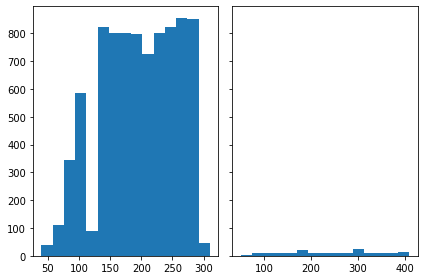

In [262]:
from matplotlib import pyplot as plt

n_bins = 15

# Generate a normal distribution, center at x=0 and y=5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(sim.application_model.response_times_by_request['auth'], bins=n_bins)
axs[1].hist(sim.application_model.response_times_by_request['buy'], bins=n_bins)

In [87]:
import numpy as np
np.median(sim.application_model.response_times_by_request['auth'])

160.0

In [ ]:
# TODO: consider scaling links?
class Link:
    def __init__(self,
                 simulation_step_ms,
                 latency,
                 bandwidth = 1000):
        # Static state
        self.latency = latency
        self.bandwidth = bandwidth
        self.simulation_step_ms = simulation_step_ms
        
        # Dynamic state
        self.requests = [] 
        
    def put_request(self, req):
        if len(self.requests) < self.bandwidth:
            req.processing_left_ms = self.latency
            self.requests.append(req)
            return True
        else:
            return False
        
    def get_requests(self):
        # Called every simulation step thus updating reqs
        reqs_to_give = []
        for req in self.requests:
            min_time_left = min(req.processing_left_ms, self.simulation_step_ms)
            if req.processing_left_ms - min_time_left <= 0:
                req.processing_left_ms = 0
                req.cumulative_time_ms += min_time_left
                reqs_to_give.append(req)
            else:
                req.processing_left_ms -= min_time_left
                
        return reqs_to_give

class NetworkModel:
    def __init__(self,
                 links_dict_in = None):
        self.links_dict_in = links_dict_in
        self.links_dict_out = {}
        
        # TODO: from file
        for link_start, outs in self.links_dict.items():
            for out, link in outs.items():
                if out in self.links_dict_out:
                    self.links_dict_out[out].append(link)
                else:
                    self.links_dict_out[out] = [link]
                    
    def put_request(self,
                    start_service_lbl,
                    end_service_lbl,
                    req):
        
        self.links_dict_in[start_service_lbl][end_service_lbl].put_request(req)
    
    def get_requests(self,
                     end_service_lbl):
        reqs = []
        links = self.links_dict_out[end_service_lbl]
        for link in links:
            reqs.extend(link.get_requests())
            
        return reqs